# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"



participants_to_replace = {
    "_GENE-Y_" : "_GENE_",
    "_GENE-N_" : "_GENE_"
}



x_column = "sentence_anonymised"
gold_y_column = "label"
prediction_y_column = "prediction"




In [2]:
s3_test_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_test_marker.json"
s3_val_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_val_marker.json"
s3_train_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_train_marker.json"

s3_largescale_high_quality_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621_negative_generalisation/highquality_sample.json"




x_column = "x"
gold_y_column = "y_raw"
prediction_y_column = "prediction"
participants_to_replace = {
    "GENEPART0" : "_GENE_",
    "GENEPART1" : "_GENE_",
    "CHEMPART1" : "_CHEMICAL_",
    "CHEMPART0" : "_CHEMICAL_",


}


In [3]:
other_genes_to_replace = {f"GENEIG{i} ":"_OTHER_ " for i in range(20)}
other_chem_to_replace = {f"CHEMIG{i} ":"_OTHER_ " for i in range(20)}

other_ignore = {**other_genes_to_replace, **other_chem_to_replace}

# markers_to_replace = {**participants_to_replace, **other_ignore }
markers_to_replace = {**participants_to_replace}

In [4]:
markers_to_replace

{'GENEPART0': '_GENE_',
 'GENEPART1': '_GENE_',
 'CHEMPART1': '_CHEMICAL_',
 'CHEMPART0': '_CHEMICAL_'}

#### Get the gold dataset from https://biocreative.bioinformatics.udel.edu/media/store/files/2017/ChemProt_Corpus.zip

In [5]:
s3_test_gold_file = "s3://aegovan-data/chemprotner/test/chemprot_test_gold_standard.tsv"

In [6]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree
from pyirr import kappa2


sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [7]:
import sys, os, pandas as pd
pd.set_option('display.max_colwidth',None)


sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [8]:
local_temp= "temp"

In [9]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)
test_gold_file  = download_s3_file( s3_test_gold_file, local_prediction_dir)
local_highquality_file = download_s3_file(s3_largescale_high_quality_prediction, local_prediction_dir)





## Utils

In [10]:
def add_key_column(df):
    df["key"] = df.apply(lambda x:"{}#{}#{}".format( x["abstract_id"], x["participant1_id"].replace("Arg1:",""), x["participant2_id"].replace("Arg2:","")), axis=1)
    return df

def load_gold(file):
    df = pd.read_csv(file, delimiter="\t", header=None, names = ["abstract_id", "relationship_type", "participant1_id","participant2_id"])
    
    return df

In [11]:

def replace_in_place(x, replacement_dict):
    for k,v in replacement_dict.items():
        x = x.replace(k,v)
    return x
    

def load_valtest_pred(file, labels_order = label_names, markers_replacement=markers_to_replace):
    df = pd.read_json(file, orient="records")
    
    # Replace names with generic markers so NB is easier
    df["x"] = df[x_column].apply(lambda x: replace_in_place(x,markers_replacement))
    # Make it easy to remember gold vs prediction column
    df = df.rename(columns={"y": "gold_index", "y_raw": "gold"})
    
    df["prediction_index"] = df[prediction_y_column].apply(lambda x: labels_order.index(x))



    

    return df



In [12]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class=100, classwise_vocab=True):
    
    max_tree_depth = 4
    min_df = min_df or 3
    
    nb_kwargs = {
        "min_df": min_df,
        "max_words_per_class":max_words_per_class, 
        "stop_words": stop_words, 
        "ngram_range": ngram_range, 
        "classwise_vocab": classwise_vocab
    }
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier("_CHEMICAL_", "_GENE_", **nb_kwargs),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words, max_tree_depth = max_tree_depth, extract_span=True, **nb_kwargs ),
      #  TREE : ModelTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words, max_tree_depth = max_tree_depth)

    }
    
    result = {}
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
             "predictions_conf": p_conf
        }
    return result


def  predict_all_classifiers(df, models_dict):
   
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result




In [13]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))
    
def float_format(x):
     return "{:.2f}".format(x)
    
def compute_kappa(r1, r2):
    python_kappa = sklearn.metrics.cohen_kappa_score(r1,r2)
    print(python_kappa)
    data = {'r1': r1,
        'r2': r2}

    df = pd.DataFrame(data)
    r_kappa = kappa2(df, weight="unweighted")
    print(r_kappa)
    
    result = {
        "python_kappa" : python_kappa,
        "r_kappa" : r_kappa.value,
        "r_pvalue":r_kappa.pvalue
        
    }
    return result

def print_report(actual, pred, labels=None, label_names = all_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
    
    
  
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    
    k_scores = compute_kappa(actual, pred )
    for k, v in k_scores.items():
        d[k] = {
            "cohen" : v,
            "support" : len(actual),

        }
        
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    

def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format,
                                                 "recall":float_percent_format, 
                                                 "f1-score":float_percent_format,
                                                 "support":int_format,
                                                "cohen":float_format
                                                }))
    return df    
    

In [14]:
    
import subprocess

def _write_chemprot_eval(df,y_col, dest_file):
   
    df = df[["abstract_id",y_col, "participant1_id", "participant2_id"]].query(f"{y_col} != 'NEGATIVE' ").copy(deep=True)
    

    df["participant1_id"] = df["participant1_id"].apply(lambda x: f"Arg1:{x}")
    df["participant2_id"] = df["participant2_id"].apply(lambda x: f"Arg2:{x}")
    df.to_csv(dest_file, sep="\t", header=False, index=False)

    
def _run_shell( cmd):
        """
        Runs a shell command
        :param cmd: The cmd to run
        """
        print("Running command\n{}".format(" ".join(cmd)))

        out = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        stdout, stderr = out.communicate()
        result = stdout.decode(encoding='utf-8')
        if stderr:
            error_msg = stderr.decode(encoding='utf-8')
            print(error_msg)
            raise Exception(error_msg)

        return result
    
def print_report_original(df,y_col, gold_file, latex=True,  jar_path="../thirdparty"):
   
    # Run original eval script to double check numbers
    _, pred_file = tempfile.mkstemp()
    _write_chemprot_eval(df,y_col, pred_file)
    output_dir = "out"
    os.makedirs(output_dir, exist_ok = True)
    cmd = ["java", "-cp" , f"{jar_path}/bc6chemprot_eval.jar", "org.biocreative.tasks.chemprot.main.Main",
           "-TP", "TRUE", "-FP", "TRUE", "-FN", "TRUE", pred_file, gold_file]
    cmd_result = _run_shell(cmd)
    print(cmd_result)

    # Result summary written to eval .txt
    with open(os.path.join(output_dir,"eval.txt"), "r") as f:
        result = f.readlines()
        print(result)
        
    # Parse detailed output file to obtain classwise stats
    names = ["abstract_id", "y", "participant1_id", "participant2_id"]
    df_fp = pd.read_csv(os.path.join(output_dir,"fp.txt"),sep="\t", header=None, names=names)
    df_fp["c"] ="FP"
    df_fn = pd.read_csv(os.path.join(output_dir,"fn.txt"),sep="\t", header=None, names=names)
    df_fn["c"] ="FN"
    df_tp = pd.read_csv(os.path.join(output_dir,"tp.txt"),sep="\t", header=None, names=names)
    df_tp["c"] ="TP"
    df = pd.concat([df_fp, df_tp, df_fn])
    
    df_test_summary = df.groupby(["y" , "c"]).size()\
                .reset_index().rename(columns={0:"total"})\
                .pivot(index="y", columns="c", values="total")
    df_test_summary.loc["total", "FN"] = df_test_summary["FN"].sum()
    df_test_summary.loc["total", "FP"] = df_test_summary["FP"].sum()
    df_test_summary.loc["total", "TP"] = df_test_summary["TP"].sum()

    df_test_summary["P"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FP"])
    df_test_summary["R"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FN"])
    df_test_summary["F"] = (2*df_test_summary["P"] * df_test_summary["R"]).div(df_test_summary["P"] +df_test_summary["R"])


    
    # Clean up
    os.remove(pred_file)
    return df_test_summary

In [15]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [16]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])




In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred, normalize=normalize)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [18]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

def add_unique_genes_chem(df):
    df["unique_chemprot_names"] = df["annotations"].apply(lambda x: sorted(list(set([ i["entity_name"] for i in x]))))
    return df



def extract_span(item: str, marker1: str, marker2: str):
    def _swap( marker1, marker2):
        return marker2, marker1

    m1 = item.find(marker1)
    m2 = item.find(marker2)
    
    # m1 occurs first
    if m1 > m2:
        marker1, marker2 = _swap(marker1, marker2)

    m1_start = item.find(marker1)

    m1_end = item.rfind(marker1)
    m2_end = item.rfind(marker2)

    end = m1_end + len(marker1) if m1_end > m2_end else m2_end + len(marker2)

    return item[m1_start: end]


def add_span_genes_chem(df):
    df["x_span"] = df["x"].apply(lambda x: extract_span(x, "_GENE_", "_CHEMICAL_"))
    df["x_span_word_len"] = df["x_span"].apply(lambda x: len(x.split(" ")))
    return df

def filter_include_min_word_len(df, min_len=5):
    return df.query(f"x_span_word_len > {min_len}").copy()

def filter_include_max_word_len(df, max_len=15):
    return df.query(f"x_span_word_len <= {max_len}").copy()




In [19]:

#     df["x"] = df[x_column].apply(lambda x: replace_in_place(x,markers_replacement))
#     df["gold"] = df[gold_y_column].apply(lambda x: labels_order.index(x))
#     df["gold_raw"] = df[gold_y_column]

#     df["y"] = df[prediction_y_column].apply(lambda x: labels_order.index(x))
#     df["y_raw"] = df[prediction_y_column]

def add_y(df,  y_column):
    df["y"] = df[y_column]
    return df

def run_analysis(df, y_column, meta_dataset, meta_target):
    df = df.copy(deep=True).pipe(add_y, y_column=y_column)
    result = train_and_predict_all_classifiers(df, min_df=1)
    
    all_labels = list(set(list(df["gold_index"].unique())).union(set(list(df["prediction_index"].unique()))))
    
    df_report = print_report_all_classifiers(df[y_column], result,  all_labels)
    #get_top_discrimintary_keywords(result[NAIVE_BAYES]["m"],0)
    summary_rec = {"df": df,
                   "df_report" :df_report,
                   "surrogate_model_result" : result,
                   "meta":[
                       { "name": "dataset" , "value": meta_dataset},
                       { "name": "T" , "value": meta_target}
                          ]
                  }


    return  summary_rec
    
    

In [20]:
all_results = []

## Train GT 

In [21]:
df_train = load_valtest_pred(local_train_prediction_file)\
                .pipe(add_unique_genes_chem)\
                .pipe(add_span_genes_chem)

In [22]:
df_train["gold"].unique()

array(['CPR:3', 'CPR:4', 'NEGATIVE', 'CPR:5', 'CPR:6', 'CPR:9'],
      dtype=object)

In [23]:
r = run_analysis(df_train,y_column="gold_index", meta_dataset = "CHM TR", meta_target = "GT" )
all_results.append(r)

Training Naive Bayes
Max words :  325
Training Naive Bayes + Tree
Max words :  325
Extracting features..for 6437
Completed..
0.45127552594558573
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 6437
  Raters = 2
   Kappa = 0.451

       z = 61.196
 p-value = 0.000

0.4649533135258065
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 6437
  Raters = 2
   Kappa = 0.465

       z = 63.486
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      53.9 &   77.7 &     63.6 &    2265 &   NaN \\
       Naive Bayes &            1 &      60.9 &   52.8 &     56.6 &     777 &   NaN \\
       Naive Bayes &            2 &      71.3 &   61.2 &     65.9 &    2260 &   NaN \\
       Naive Bayes &            3 &      84.4 &   53.2 &     65.2 &     173 &   NaN \\
       Naive Bayes &            4 &      75.9 &   44.3 &     55.9 &     235 &   NaN \\
   

<AxesSubplot:ylabel='Frequency'>

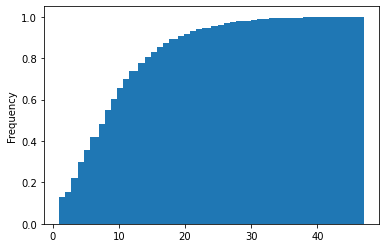

In [24]:
df_train["x_span_word_len"].plot.hist(bins=100, cumulative=True, density=True)

In [25]:
df_train.groupby("gold")["x_span_word_len"].describe(percentiles=[.25,.5,.75,.90])

,count,mean,std,min,25%,50%,75%,90%,max
gold,,,,,,,,,
CPR:3,777.0,10.584299,7.530242,1.0,5.0,9.0,14.0,20.0,45.0
CPR:4,2260.0,9.400442,7.070147,1.0,4.0,8.0,13.0,19.0,43.0
CPR:5,173.0,8.317919,7.442616,1.0,3.0,6.0,11.0,20.8,37.0
CPR:6,235.0,6.442553,7.202793,1.0,2.5,4.0,7.5,17.0,36.0
CPR:9,727.0,7.969739,6.667149,1.0,2.0,7.0,11.0,18.0,31.0
NEGATIVE,2265.0,9.568653,7.429337,1.0,4.0,8.0,13.0,19.6,47.0


<AxesSubplot:ylabel='Frequency'>

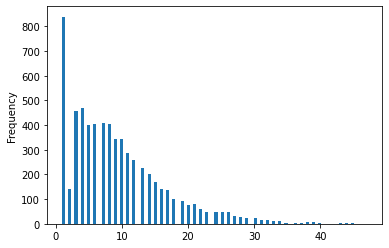

In [26]:
df_train["x_span_word_len"].plot.hist(bins=100)

In [27]:
get_top_discrimintary_keywords(all_results[-1]["surrogate_model_result"][NAIVE_BAYES]["m"],1)[:50]

[('_chemical_', -1.8336350001234472),
 ('_gene_', -1.8336350001234472),
 ('increased', -3.5390768142072453),
 ('induced', -3.722926255179253),
 ('expression', -3.7414453029464907),
 ('increase', -4.110209044204226),
 ('activity', -4.336736693502677),
 ('activation', -4.48244850468407),
 ('significantly', -4.52245383929777),
 ('geneig2', -4.630084503490135),
 ('geneig4', -4.6766045191250285),
 ('geneig5', -4.7007020707040885),
 ('geneig9', -4.75071249127875),
 ('cells', -4.75071249127875),
 ('geneig1', -4.803356224764173),
 ('geneig3', -4.803356224764173),
 ('phosphorylation', -4.8307551989522866),
 ('geneig0', -4.8307551989522866),
 ('geneig6', -4.858926075918983),
 ('geneig10', -4.858926075918983),
 ('induction', -4.858926075918983),
 ('treatment', -4.858926075918983),
 ('apoptosis', -4.917766575941917),
 ('geneig8', -4.98028693292325),
 ('geneig7', -4.98028693292325),
 ('geneig13', -5.013076755746241),
 ('protein', -5.046978307421922),
 ('geneig11', -5.082069627233192),
 ('geneig12',

### Train with filter to remove short sentences

In [28]:
df_train_filter = df_train\
                    .pipe(add_span_genes_chem)\
                    .pipe(filter_include_min_word_len)
r = run_analysis(df_train_filter,y_column="gold_index", meta_dataset = "CHM TR Exclude short sentences", meta_target = "GT" )
all_results.append(r)



Training Naive Bayes
Max words :  337
Training Naive Bayes + Tree
Max words :  337
Extracting features..for 4131
Completed..
0.5305698007063935
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 4131
  Raters = 2
   Kappa = 0.531

       z = 55.641
 p-value = 0.000

0.5218905747767307
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 4131
  Raters = 2
   Kappa = 0.522

       z = 54.699
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      65.6 &   71.1 &     68.2 &    1506 &   NaN \\
       Naive Bayes &            1 &      58.7 &   62.0 &     60.3 &     555 &   NaN \\
       Naive Bayes &            2 &      70.3 &   71.9 &     71.1 &    1491 &   NaN \\
       Naive Bayes &            3 &      81.7 &   56.3 &     66.7 &      87 &   NaN \\
       Naive Bayes &            4 &      70.3 &   57.7 &     63.4 &      78 &   NaN \\
    

## Val GT predictions


In [29]:
df_val = load_valtest_pred(local_val_prediction_file)

r = run_analysis(df_val,y_column="gold_index", meta_dataset = "CHM VAL", meta_target = "GT" )
all_results.append(r)


Training Naive Bayes
Max words :  334
Training Naive Bayes + Tree
Max words :  334
Extracting features..for 3558
Completed..
0.5386840529150538
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 3558
  Raters = 2
   Kappa = 0.539

       z = 58.732
 p-value = 0.000

0.5545302045741431
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 3558
  Raters = 2
   Kappa = 0.555

       z = 59.961
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      54.3 &   76.4 &     63.5 &    1131 &   NaN \\
       Naive Bayes &            1 &      71.2 &   60.1 &     65.2 &     552 &   NaN \\
       Naive Bayes &            2 &      74.1 &   67.0 &     70.4 &    1103 &   NaN \\
       Naive Bayes &            3 &      75.6 &   56.0 &     64.4 &     116 &   NaN \\
       Naive Bayes &            4 &      82.1 &   59.8 &     69.2 &     199 &   NaN \\
    

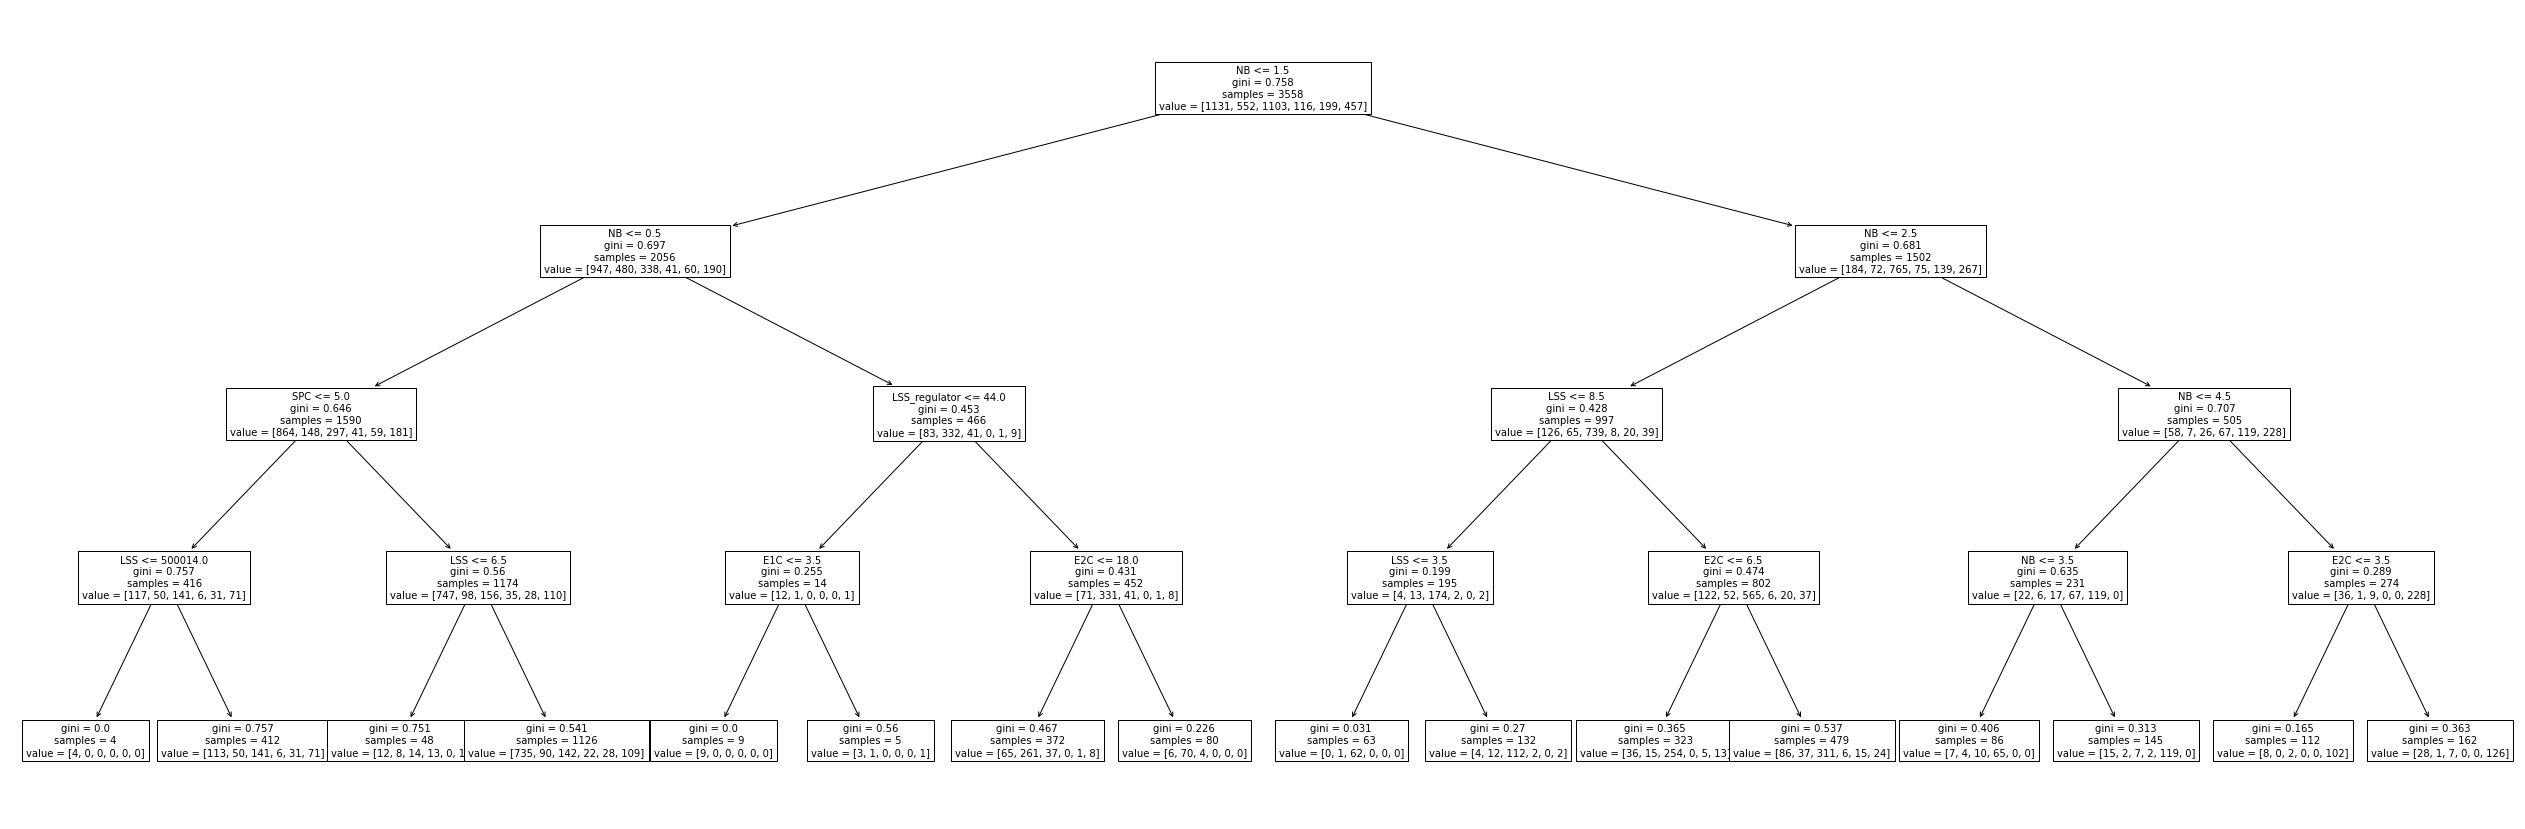

In [32]:
plot_tree(r["surrogate_model_result"][NAIVE_BAYES_WITH_TREE]["m"])

## Test 

In [33]:
def filter_is_eval(df):
    # The chemprot scoring script only evalutes the one with "Y"
    df = df.query("is_eval == 'Y'").copy()
    
    return df

In [34]:
df_test_eval_only = load_valtest_pred(local_test_prediction_file).pipe(filter_is_eval)


print_report_original(df_test_eval_only, "prediction", test_gold_file )


Running command
java -cp ../thirdparty/bc6chemprot_eval.jar org.biocreative.tasks.chemprot.main.Main -TP TRUE -FP TRUE -FN TRUE /var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/tmp3d928zme temp/prediction/chemprot_test_gold_standard.tsv

The file:
	./out/eval.txt
was successfully created.

The file:
	./out/tp.txt
was successfully created.

The file:
	./out/fp.txt
was successfully created.

The file:
	./out/fn.txt
was successfully created.

['\n', 'Total annotations: 3458\n', 'Total predictions: 3107\n', 'TP: 2853\n', 'FN: 605\n', 'FP: 254\n', 'Precision: 0.9182491149018346\n', 'Recall: 0.8250433776749566\n', 'F-score: 0.8691546077684691']


c,FN,FP,TP,P,R,F
y,,,,,,
CPR:3,152.0,67.0,513.0,0.884483,0.771429,0.824096
CPR:4,262.0,80.0,1399.0,0.945909,0.842264,0.891083
CPR:5,37.0,12.0,158.0,0.929412,0.810256,0.865753
CPR:6,48.0,24.0,245.0,0.910781,0.836177,0.871886
CPR:9,106.0,51.0,538.0,0.913413,0.835404,0.872668
total,605.0,234.0,2853.0,0.924198,0.825043,0.871811


In [37]:
l = 'CPR:3'
tp = df_test_eval_only.query(f"prediction=='{l}' and gold=='{l}'").shape[0]
fp = df_test_eval_only.query(f"prediction=='{l}' and gold!='{l}'").shape[0]
fn = df_test_eval_only.query(f"prediction!='{l}' and gold=='{l}'").shape[0]


fn, fp, tp

(152, 68, 515)

In [40]:

print_report(df_test_eval_only["gold"],df_test_eval_only["prediction"])

0.7571643551714192
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 3469
  Raters = 2
   Kappa = 0.757

       z = 84.148
 p-value = 0.000



,precision,recall,f1-score,support,cohen
CPR:3,0.883362,0.772114,0.824000,667.000000,NaN
CPR:4,0.944220,0.842831,0.890650,1667.000000,NaN
CPR:5,0.893258,0.803030,0.845745,198.000000,NaN
CPR:6,0.910781,0.836177,0.871886,293.000000,NaN
CPR:9,0.913413,0.835404,0.872668,644.000000,NaN
NEGATIVE,0.000000,0.000000,0.000000,0.000000,NaN
accuracy,0.825022,0.825022,0.825022,0.825022,0.825022
macro avg,0.757506,0.681593,0.717491,3469.000000,NaN
weighted avg,0.921066,0.825022,0.870349,3469.000000,NaN
python_kappa,NaN,NaN,NaN,3469.000000,0.757164


In [41]:
df_test_eval_only["abstract_id"].shape, df_test_eval_only["abstract_id"].nunique()

((3469,), 514)

### Predict Test on Test GT fit

In [42]:
df_test = load_valtest_pred(local_test_prediction_file)

r = run_analysis(df_test,y_column="gold_index", meta_dataset = "CHM TS", meta_target = "GT" )
all_results.append(r)



Training Naive Bayes
Max words :  323
Training Naive Bayes + Tree
Max words :  323
Extracting features..for 5744
Completed..
0.47908974352041567
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 5744
  Raters = 2
   Kappa = 0.479

       z = 64.191
 p-value = 0.000

0.4828853954700585
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 5744
  Raters = 2
   Kappa = 0.483

       z = 64.731
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      57.4 &   85.4 &     68.6 &    2275 &   NaN \\
       Naive Bayes &            1 &      63.2 &   46.2 &     53.4 &     667 &   NaN \\
       Naive Bayes &            2 &      78.1 &   60.4 &     68.1 &    1667 &   NaN \\
       Naive Bayes &            3 &      69.5 &   49.5 &     57.8 &     198 &   NaN \\
       Naive Bayes &            4 &      76.6 &   41.3 &     53.7 &     293 &   NaN \\
   

In [43]:
df_test.prediction.unique()

array(['NEGATIVE', 'CPR:6', 'CPR:4', 'CPR:9', 'CPR:3', 'CPR:5'],
      dtype=object)

In [44]:
df_test.prediction_index.unique()

array([0, 4, 2, 5, 1, 3])

### Predict Test on Test Prediction fit 

In [45]:

r = run_analysis(df_test,y_column="prediction_index", meta_dataset = "CHM TS", meta_target = "BP" )
all_results.append(r)



Training Naive Bayes
Max words :  315
Training Naive Bayes + Tree
Max words :  315
Extracting features..for 5744
Completed..
0.5026810167988787
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 5744
  Raters = 2
   Kappa = 0.503

       z = 69.389
 p-value = 0.000

0.5062389159900134
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 5744
  Raters = 2
   Kappa = 0.506

       z = 69.934
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      55.3 &   84.1 &     66.8 &    2018 &   NaN \\
       Naive Bayes &            1 &      65.5 &   56.2 &     60.5 &     771 &   NaN \\
       Naive Bayes &            2 &      78.2 &   60.8 &     68.4 &    1725 &   NaN \\
       Naive Bayes &            3 &      77.8 &   53.6 &     63.4 &     196 &   NaN \\
       Naive Bayes &            4 &      71.5 &   46.0 &     56.0 &     300 &   NaN \\
    

## Large scale high quality

In [51]:
import random
def randomly_sample(df, max_sample = 10000, seed=None):
    frac = max_sample/len(df)
    return df.groupby('prediction_index', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=seed)).copy()
    
    
def multiple_random_sample_runs(df, max_sample = 10000, runs=10) :   
    random.seed(42)
    result = []
    for i in range(runs):
        new_seed = random.randint(10,1000)
        sample_df = randomly_sample(df, seed = new_seed)
    
        result.append(sample_df)
    return result
        
    
    

In [52]:
df_highquality = load_valtest_pred(local_highquality_file)\
                .pipe(add_span_genes_chem)\
               # .pipe(filter_include_max_word_len, 19)

In [59]:
len(df_highquality),  df_highquality["abstract_id"].nunique()

(40120, 14350)

In [53]:
random_runs = multiple_random_sample_runs(df_highquality, runs=10)

In [54]:
def compute_nb_multiple_runs(multi_runs):
    result = []
    for i, df in enumerate(multi_runs):
        r = run_analysis(df,y_column="prediction_index", meta_dataset = "GH {i}", meta_target = "BP" )


        df["sm_nb_predictions"]=r["surrogate_model_result"][NAIVE_BAYES]["predictions"]
        
        result.append( r["surrogate_model_result"] )
    return result
        
random_runs_results = compute_nb_multiple_runs(random_runs)

Training Naive Bayes
Max words :  214
Training Naive Bayes + Tree
Max words :  214
Extracting features..for 10000
Completed..
0.4330548670784947
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.433

       z = 78.288
 p-value = 0.000

0.43649869888742376
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.436

       z = 78.863
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      50.5 &   51.1 &     50.8 &    2493 &   NaN \\
       Naive Bayes &            1 &      56.0 &   55.7 &     55.9 &    2357 &   NaN \\
       Naive Bayes &            2 &      59.6 &   56.5 &     58.0 &    2492 &   NaN \\
       Naive Bayes &            3 &      22.2 &  100.0 &     36.4 &       2 &   NaN \\
       Naive Bayes &            4 &      49.3 &   77.9 &     60.4 &     213 &   NaN \\


Training Naive Bayes
Max words :  212
Training Naive Bayes + Tree
Max words :  212
Extracting features..for 10000
Completed..
0.4355423211268936
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.436

       z = 79.102
 p-value = 0.000

0.438881222808874
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.439

       z = 79.722
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      53.2 &   53.4 &     53.3 &    2493 &   NaN \\
       Naive Bayes &            1 &      55.0 &   56.0 &     55.5 &    2357 &   NaN \\
       Naive Bayes &            2 &      60.3 &   54.5 &     57.3 &    2492 &   NaN \\
       Naive Bayes &            3 &      40.0 &  100.0 &     57.1 &       2 &   NaN \\
       Naive Bayes &            4 &      39.2 &   73.7 &     51.2 &     213 &   NaN \\
  

Training Naive Bayes
Max words :  228
Training Naive Bayes + Tree
Max words :  228
Extracting features..for 10000
Completed..
0.4461602582613229
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.446

       z = 80.881
 p-value = 0.000

0.450285855281783
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.450

       z = 81.662
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      54.3 &   52.3 &     53.3 &    2493 &   NaN \\
       Naive Bayes &            1 &      55.3 &   58.4 &     56.8 &    2357 &   NaN \\
       Naive Bayes &            2 &      59.3 &   54.9 &     57.0 &    2492 &   NaN \\
       Naive Bayes &            3 &     100.0 &  100.0 &    100.0 &       2 &   NaN \\
       Naive Bayes &            4 &      44.4 &   78.4 &     56.7 &     213 &   NaN \\
  

Training Naive Bayes
Max words :  234
Training Naive Bayes + Tree
Max words :  234
Extracting features..for 10000
Completed..
0.4476675574410649
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.448

       z = 80.661
 p-value = 0.000

0.45274896684554855
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 10000
  Raters = 2
   Kappa = 0.453

       z = 81.603
 p-value = 0.000

\begin{tabular}{llrrrrr}
\toprule
             model &        index & precision & recall & f1-score & support & cohen \\
\midrule
       Naive Bayes &            0 &      54.7 &   54.5 &     54.6 &    2493 &   NaN \\
       Naive Bayes &            1 &      55.2 &   55.5 &     55.3 &    2357 &   NaN \\
       Naive Bayes &            2 &      59.2 &   56.9 &     58.1 &    2492 &   NaN \\
       Naive Bayes &            3 &      66.7 &  100.0 &     80.0 &       2 &   NaN \\
       Naive Bayes &            4 &      52.7 &   73.7 &     61.4 &     213 &   NaN \\


In [63]:
def compute_multiple_runs_cohen_kappa(runs_df, runs_results):
    result = []
    for i, (df, df_sm_results) in enumerate(zip(runs_df, runs_results)):
        score_nb = sklearn.metrics.cohen_kappa_score(df["prediction_index"],
                                  df_sm_results[NAIVE_BAYES]["predictions"]
                                  )
        score_nbt = sklearn.metrics.cohen_kappa_score(df["prediction_index"],
                                  df_sm_results[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )
        
        result.append({
            "run" : i,
            "size" : len(df),
            "score_nb": score_nb,
            "score_nbt": score_nbt
        })
    result = pd.DataFrame(result)    
    return result

In [64]:
df_k = compute_multiple_runs_cohen_kappa(random_runs, random_runs_results)

In [65]:
df_k

,run,size,score_nb,score_nbt
0,0,10000,0.433055,0.436499
1,1,10000,0.438833,0.444061
2,2,10000,0.434391,0.438115
3,3,10000,0.435542,0.438881
4,4,10000,0.436081,0.440987
5,5,10000,0.432676,0.435873
6,6,10000,0.446160,0.450286
7,7,10000,0.441443,0.444284
8,8,10000,0.442399,0.444536
9,9,10000,0.447668,0.452749


In [66]:
df_k.agg(score_nb_mean = ("score_nb", "mean"), score_nb_sem = ("score_nb", "sem"),  
        
        score_nbt_mean = ("score_nbt", "mean"), score_nbt_sem = ("score_nbt", "sem"),  
        )

,score_nb,score_nbt
score_nb_mean,0.438825,NaN
score_nb_sem,0.001702,NaN
score_nbt_mean,NaN,0.442627
score_nbt_sem,NaN,0.001794


## Prepare latex

In [47]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT"
    }

    for item in meta_dict_df:
        df= item["df_report"].copy(deep=True)
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    


df_summ = prepare_latex (all_results, index_filter = ["python_kappa",  "r_pvalue"] )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format,
                                                  "recall":float_percent_format, 
                                                  "f1-score":float_percent_format,
                                                  "support":int_format,
                                                 "cohen":float_format}))

\begin{tabular}{llllrrrrr}
\toprule
                       dataset &  T & model &        index & precision & recall & f1-score & support & cohen \\
\midrule
                        CHM TR & GT &    NB & python\_kappa &       NaN &    NaN &      NaN &    6437 &  0.45 \\
                        CHM TR & GT &    NB &     r\_pvalue &       NaN &    NaN &      NaN &    6437 &  0.00 \\
                        CHM TR & GT &   NBT & python\_kappa &       NaN &    NaN &      NaN &    6437 &  0.46 \\
                        CHM TR & GT &   NBT &     r\_pvalue &       NaN &    NaN &      NaN &    6437 &  0.00 \\
CHM TR Exclude short sentences & GT &    NB & python\_kappa &       NaN &    NaN &      NaN &    4131 &  0.53 \\
CHM TR Exclude short sentences & GT &    NB &     r\_pvalue &       NaN &    NaN &      NaN &    4131 &  0.00 \\
CHM TR Exclude short sentences & GT &   NBT & python\_kappa &       NaN &    NaN &      NaN &    4131 &  0.52 \\
CHM TR Exclude short sentences & GT &   NBT &     r\